In [200]:
import numpy as np
from UAV import *
import random
from sklearn.manifold import MDS
import matplotlib.pyplot as plt           # for plotting

Definition of the Distance Matrix

In [201]:
n_robots = int(input("number of robots: "))
platoon = []

# initialization of n robots
for i in range(n_robots):
    if i==0:
        i_robot = Robot("op_" + str(i),0,0,0)
    else:
        i_robot = Robot("op_" + str(i),random.uniform(0, 10.0),random.uniform(0, 10.0),0)
    platoon.append(i_robot)

coordinates = [[],[],[]]
S = []
for rob in platoon:
    coordinates = np.append(coordinates,rob.get_coords(),axis=1)

for i in range(len(coordinates[1])):
    S.append([coordinates[0,i], coordinates[1,i]])
S = np.array(S)

DM = d_matrix(platoon)
print(DM)

[[ 0.          7.79647416 11.7826607 ]
 [ 7.79647416  0.          4.9545574 ]
 [11.7826607   4.9545574   0.        ]]


Identity matrix

In [202]:
I   = np.eye(n_robots)
print(I)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


Definition of the e vector and the H matrix

In [203]:
e   = np.array([[1] for i in range(n_robots)])

H = I - (e*e.T)/n_robots
print(H)

[[ 0.66666667 -0.33333333 -0.33333333]
 [-0.33333333  0.66666667 -0.33333333]
 [-0.33333333 -0.33333333  0.66666667]]


Eigendecomposition of the matrix -1/2*H*D*H

In [204]:
print(-1/2*H*DM*H,'\n')

#Eigenvalues ev, eigenvectors EV
ev,EV = np.linalg.eig(-1/2*H*DM*H)

#Lambda is the diagonal matrix whose elements are the eigenvalues
LAMBDA = np.eye(n_robots)*ev

#U is the matrix whose columns are the eigenvectors
U      = np.transpose(EV)
print(LAMBDA,'\n\n',U)

#Sstar  = np.sqrt(LAMBDA).transpose(U)
#print(Sstar)

[[-0.         -0.43313745 -0.65459226]
 [-0.43313745 -0.         -0.27525319]
 [-0.65459226 -0.27525319 -0.        ]] 

[[-0.92744697  0.          0.        ]
 [-0.          0.67992938  0.        ]
 [-0.          0.          0.24751759]] 

 [[-0.64445981 -0.47808287 -0.59674812]
 [-0.74574349  0.22056362  0.62866393]
 [ 0.16893253 -0.85016967  0.49867157]]


Scikit learn MDS approach

In [205]:
n_components = 2                                   # p, reduced dimensionality space
embedding = MDS(n_components=2,n_init = 20,max_iter = 1000,random_state = 73073,dissimilarity='precomputed') # instantiate and set the hyperparameter
MDS_transformed = embedding.fit_transform(DM)
MDS_transformed.shape
print(MDS_transformed)
print(S)

[[-6.33489107 -1.10680373]
 [ 1.54217776 -1.36960436]
 [ 4.79271331  2.47640809]]
[[0.         0.        ]
 [4.49252966 6.37198451]
 [9.39084425 7.1163992 ]]


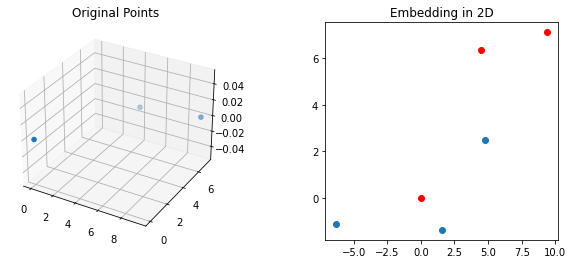

In [206]:
fig = plt.figure(2, (10,4))
ax = fig.add_subplot(121, projection='3d')
ax.scatter3D(coordinates[0,:], coordinates[1,:], coordinates[2,:])
plt.title('Original Points')

ax = fig.add_subplot(122)
plt.scatter(MDS_transformed[:,0], MDS_transformed[:,1])
plt.scatter(S[:,0], S[:,1], color='red')
plt.title('Embedding in 2D')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

Introduction of the controlled displacement

In [207]:
deltaSprime = np.array([[0,0] for i in range(n_robots)],dtype=float)
deltaSprime[0] = [0.1,0.1]
print(deltaSprime)

Sprime = S + deltaSprime
print(Sprime)

[[0.1 0.1]
 [0.  0. ]
 [0.  0. ]]
[[0.1        0.1       ]
 [4.49252966 6.37198451]
 [9.39084425 7.1163992 ]]


Phi prime definition

In [209]:
Phiprime = np.array([np.diag(Sprime@np.transpose(Sprime))]).T
print(Phiprime)

DMprime = Phiprime@e.T - 2*Sprime@Sprime.T + e@Phiprime.T
print(DMprime)

[[2.00000000e-02]
 [6.07850093e+01]
 [1.38831093e+02]]
[[  0.          58.63210649 135.54964459]
 [ 58.63210649   0.          24.54763899]
 [135.54964459  24.54763899   0.        ]]


DMprime breakdown analysis (as on the paper)

In [227]:
piece1 = DM - DMprime
print(piece1)

piece2 = (np.ones(n_robots)-np.eye(n_robots))*(0.1**2*2)
print(piece2)

piece3 = -2*((S@deltaSprime.T).T + S@deltaSprime.T)
print(piece3)

print(piece1+piece2+piece3)

[[   0.          -50.83563233 -123.76698389]
 [ -50.83563233    0.          -19.59308159]
 [-123.76698389  -19.59308159    0.        ]]
[[0.   0.02 0.02]
 [0.02 0.   0.02]
 [0.02 0.02 0.  ]]
[[-0.         -2.17290283 -3.30144869]
 [-2.17290283 -0.         -0.        ]
 [-3.30144869 -0.         -0.        ]]
[[   0.          -52.98853516 -127.04843258]
 [ -52.98853516    0.          -19.57308159]
 [-127.04843258  -19.57308159    0.        ]]
